# Session 5 - Image Segmentation and U-NET for Biomedical Image Segmentation

## Image Segmentation: Semantic Segmentation vs. Instance Segmentation

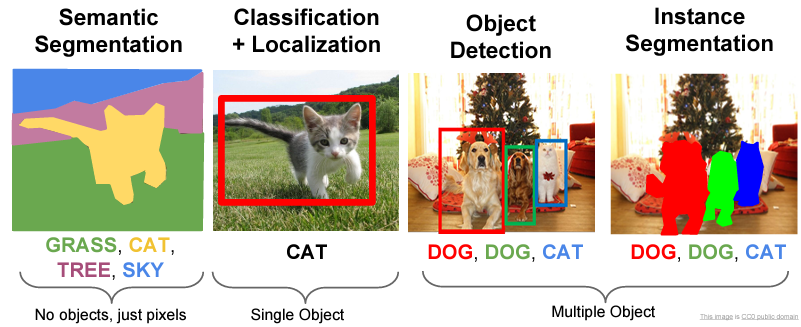

### DEMO 1: Image Segmentation using Fully Convolutional Networks (FCNs)

<b>Fully Convolutional Networks (FCNs):</b> FCNs are designed for end-to-end segmentation tasks. They take an input image and produce a corresponding segmentation map.

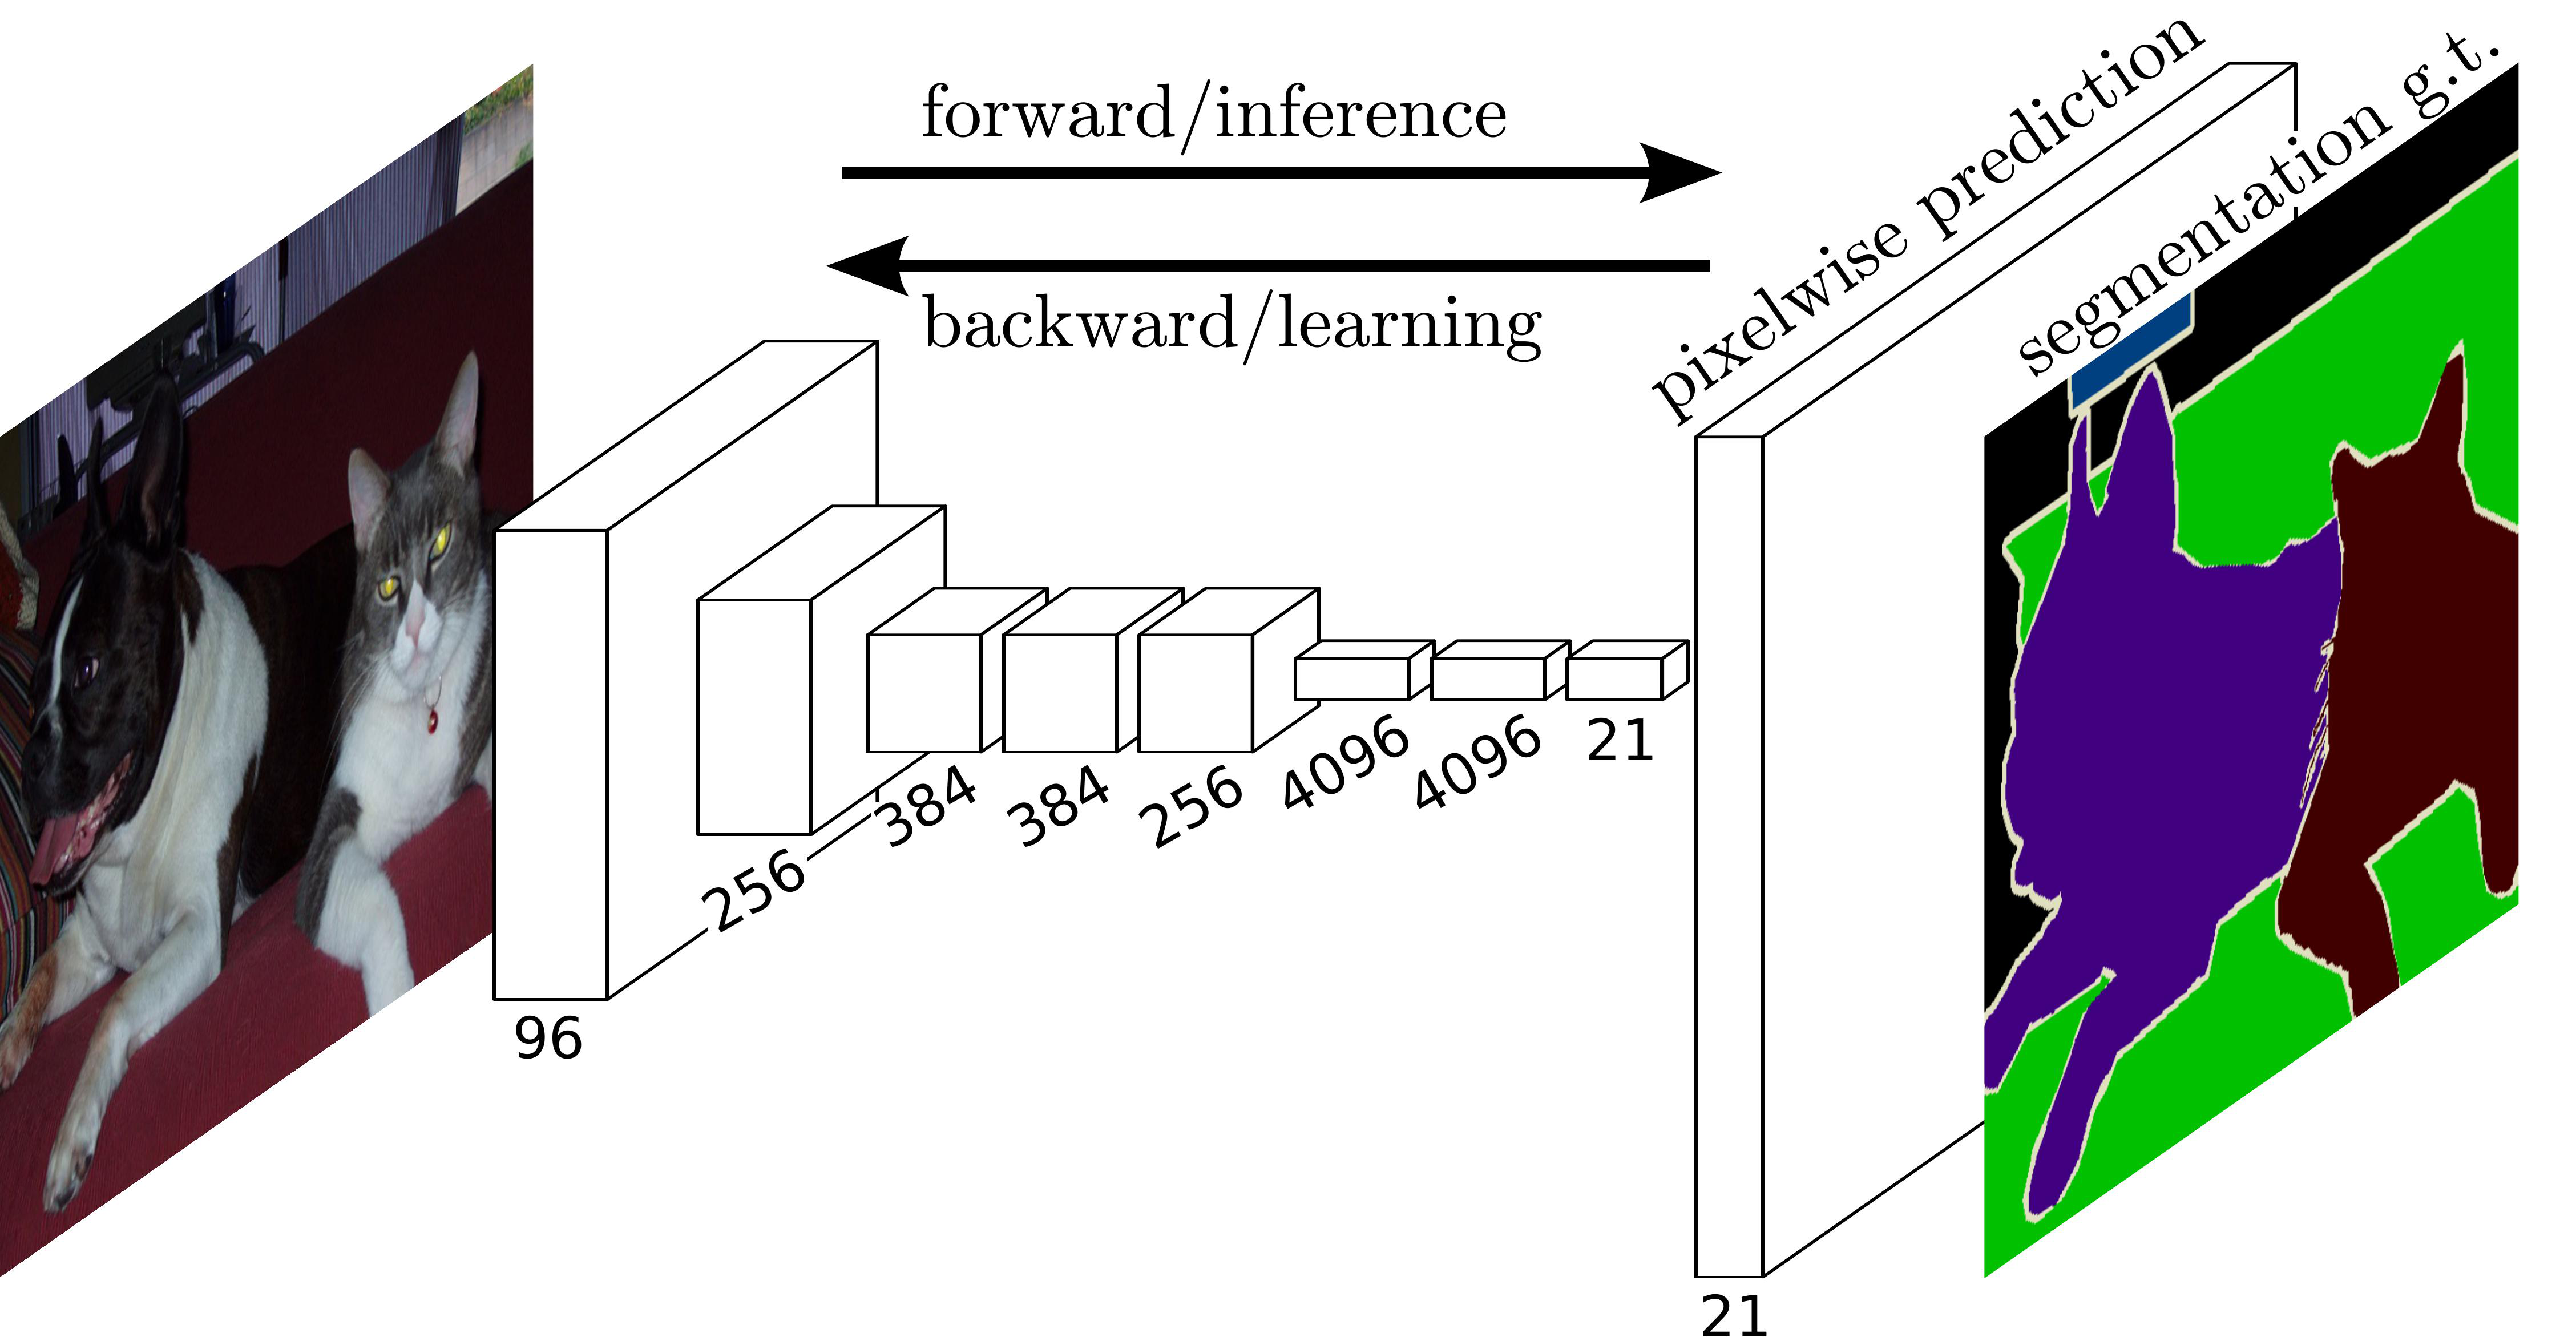

<b>FCNs Architecture: </b>
<ul>
    <li>Input Image</li>
    <li>Convolutional Layers</li>
    <li>Pooling Layers</li>
    <li>Convolutional Layers</li>
    <li>Upsampling Layers</li>
    <li>Output Segmentation Map</li>
</ul>

<b>Training:</b> The FCN is trained on a dataset with annotated images, where each pixel in the training images is labeled with its corresponding class (e.g., road, car, sky). Loss Function: Typically, a pixel-wise cross-entropy loss is used to compare the predicted segmentation map with the ground truth labels.

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [70]:
# Define a basic FCN-like architecture
def fcn_model(input_shape, num_classes):
    model = models.Sequential()
    
    # Encoder
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    
    # Decoder
    model.add(layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(num_classes, (1, 1), activation='softmax', padding='valid'))
    
    return model

# Define input shape and number of classes (e.g., for semantic segmentation)
input_shape = (256, 256, 3)  # Assuming 256x256 RGB images
num_classes = 200  # For example, in the case of the Pascal VOC dataset

# Create the model
model = fcn_model(input_shape, num_classes)

# Compile the model (you may choose a different optimizer and loss function depending on your task)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_92 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_94 (Conv2D)          (None, 64, 64, 256)       295168    
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 64, 64, 128)     

In [71]:
import cv2

# Load an image
image = cv2.imread('./ressources/zidan_materazzi_06.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
image = cv2.resize(image, (256, 256))  # Resize the image to match the input shape of the model

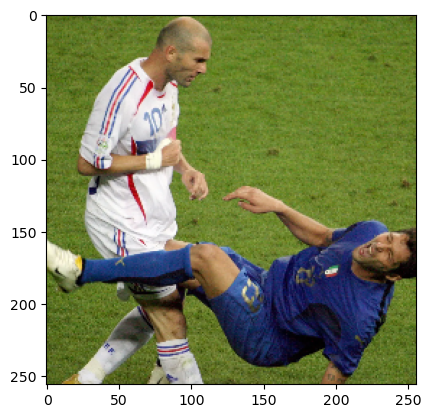

In [72]:
# Convert BGR image to RGB (Matplotlib uses RGB)
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.imshow(image)

In [73]:
image = image / 255.0  # Normalize pixel values to [0, 1]

In [74]:
image = tf.expand_dims(image, axis=0)  # Add batch dimension

In [75]:
# Load the model (assuming you have defined fcn_model earlier)
model = fcn_model(input_shape=(256, 256, 3), num_classes=num_classes)

# Compile the model (you may choose a different optimizer and loss function depending on your task)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [76]:
segmentation_map = model.predict(image)

1/1 [==============================] - 0s 347ms/step


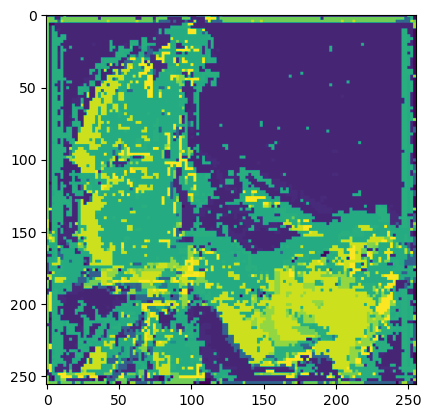

In [77]:
import matplotlib.pyplot as plt

plt.imshow(segmentation_map[0].argmax(axis=-1))  # Assuming segmentation_map is in shape (1, 256, 256, num_classes)
plt.show()

# U-Net for Biomedical Image Segementation

### U-NET ARCHITECTURE

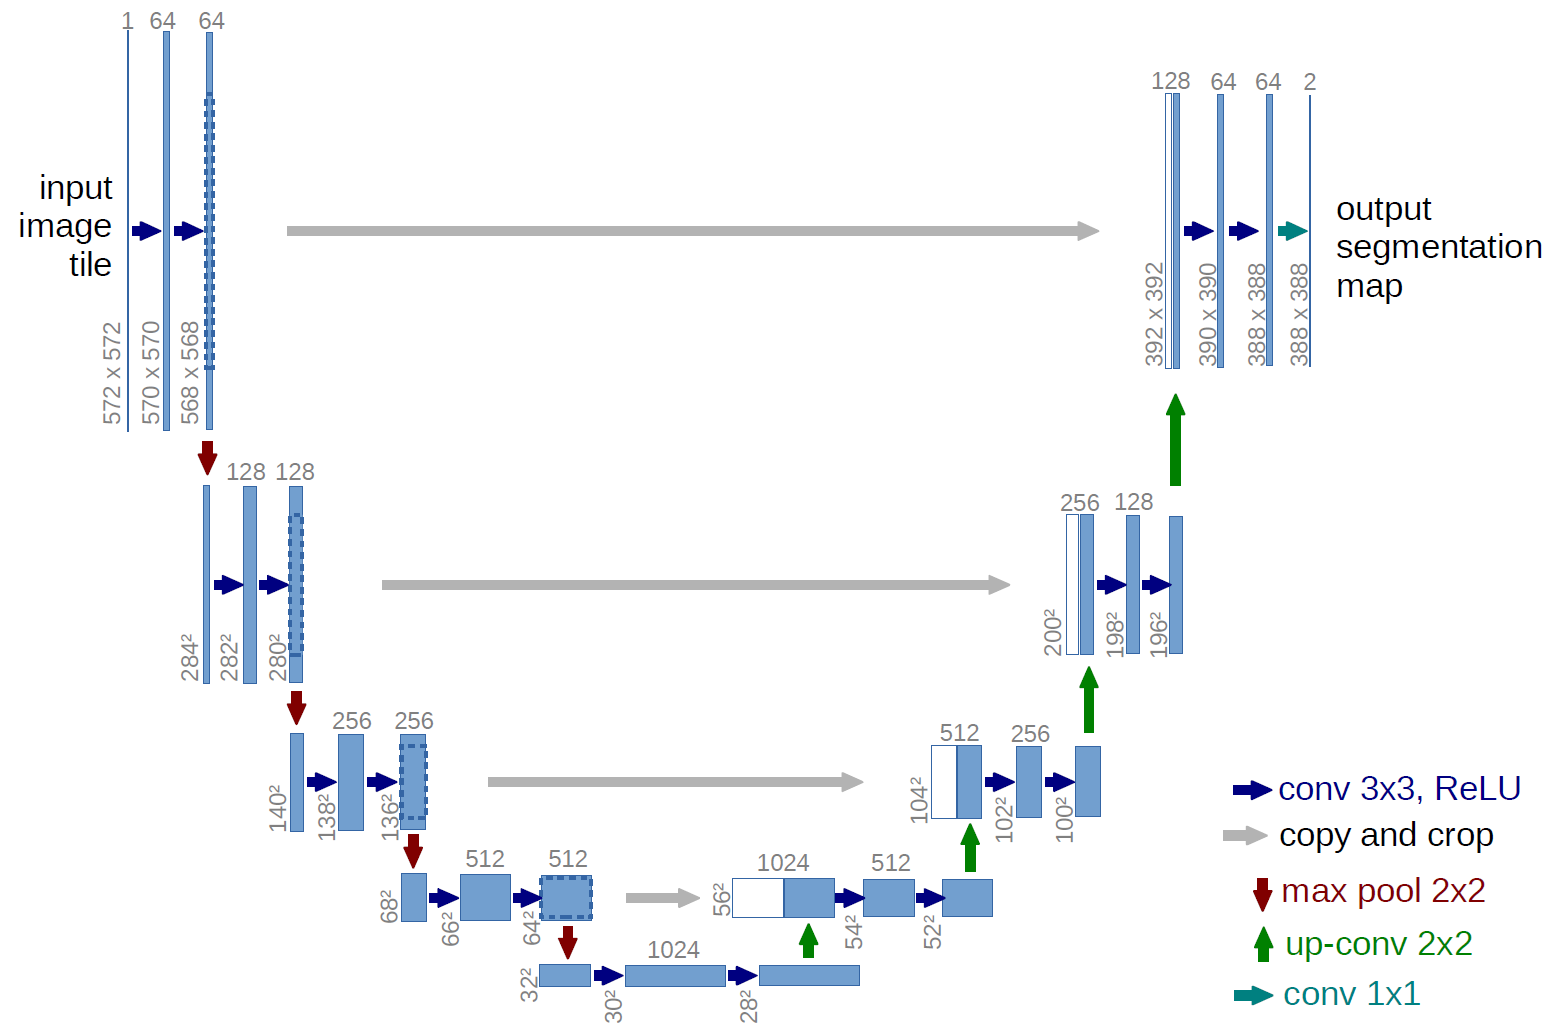

<b>Demo 1 Link: </b>https://www.kaggle.com/code/divyareddyrecharla/unet-augmentation-segmentation-models

<b>Demo 2 Link: </b>https://www.tensorflow.org/tutorials/images/segmentation

In [61]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [3]:
# Loading the Oxford-IIIT Pets dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\jairiidriss\tensorflow_datasets\oxford_iiit_pet\3.2.0.incompleteVYHRVS\oxford_iiit_pet-trai…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\jairiidriss\tensorflow_datasets\oxford_iiit_pet\3.2.0.incompleteVYHRVS\oxford_iiit_pet-test…

Dataset oxford_iiit_pet downloaded and prepared to C:\Users\jairiidriss\tensorflow_datasets\oxford_iiit_pet\3.2.0. Subsequent calls will reuse this data.


In [4]:
# Normalization function
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [5]:
# Loading images function
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
    )

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
## Image Augmentation Task:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [10]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [12]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
        plt.show()

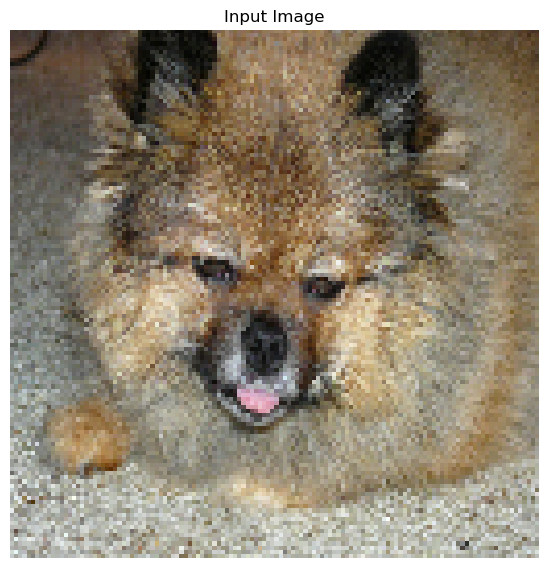

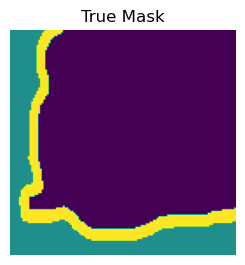

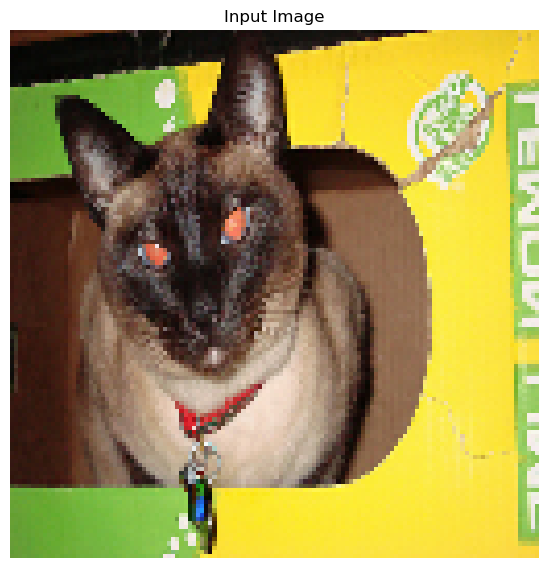

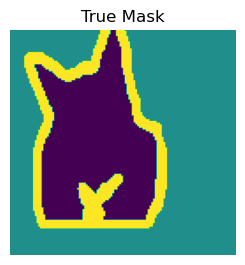

In [15]:
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

### Defining the model


The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). To learn robust features and reduce the number of trainable parameters, use a pretrained model—MobileNetV2—as the encoder. For the decoder, you will use the upsample block, which is already implemented in the pix2pix example in the TensorFlow Examples repo.

In [16]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [17]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

NameError: name 'pix2pix' is not defined